In [5]:
!pip install matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
# %% [markdown]
# ## 1. Import Libraries
#
# We import the necessary libraries for data handling, visualization, and machine learning.

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Set style for plots
sns.set(style="whitegrid")


In [8]:
# %% [markdown]
# ## 2. Load and Prepare the Data
#
# Here, we load the JSON file and normalize it into a flat DataFrame.
# In this example, we assume the JSON file contains a list of records.

# Replace 'data.json' with the path to your JSON file.
with open('/Users/shrijayan.rajendran/projects/personal/monk/monk_modernbert/dataset/medical_mimic_new_(1) copy.json', 'r') as f:
    data = json.load(f)

# Normalize the nested JSON structure
df = pd.json_normalize(data)

# Display the first few rows to understand the data structure
df.head()


,nlp_tasks,raw_data.text,raw_data.subreddit,raw_data.category,raw_data.id,parsed_data.query,parsed_data.cats,parsed_data.other_cats,parsed_data.severity,parsed_data.immediate_action_required
0,None,"Or some variation. I really am not suicidal, b...",r/CPTSD,r/CPTSD,1c2v3y0,Experiencing intrusive thoughts about self-har...,"[self_harm, medical_psychiatric_diagnosis]","[Intrusive Thoughts, Anxiety Management, Menta...",medium,False
1,None,Trigger Warning: Mentions of different types S...,r/selfharm,r/selfharm,1g9whaj,Post listing various self-harm methods while s...,"[self_harm, extreme_distress]","[Mental Health Support, Crisis Prevention, Sel...",high,True
2,None,To anyone feeling like they don't want to be h...,r/SuicideWatch,r/SuicideWatch,1ec794w,Individual expressing chronic suicidal thought...,"[self_harm, medical_psychiatric_diagnosis, ext...","[Depression Support, Suicide Prevention, Addic...",critical,True
3,None,"I've been so stressed lately, but so far I've ...",r/AdultSelfHarm,r/AdultSelfHarm,1eir6ij,Individual expressing urges for self-harm with...,"[self_harm, extreme_distress]","[Crisis Intervention, Impulse Control, Workpla...",high,True
4,None,Here’s something I made after watching the fir...,r/troubledteens,r/troubledteens,1bvctis,User references watching Synanon documentary a...,[medical_psychiatric_diagnosis],"[Addiction Recovery, Institutional Trauma, Tre...",medium,False


/var/folders/h4/8l1qm8k97mn4whg778yd7ckw0000gn/T/ipykernel_5323/1644269813.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='parsed_data.severity', data=df, palette='pastel')


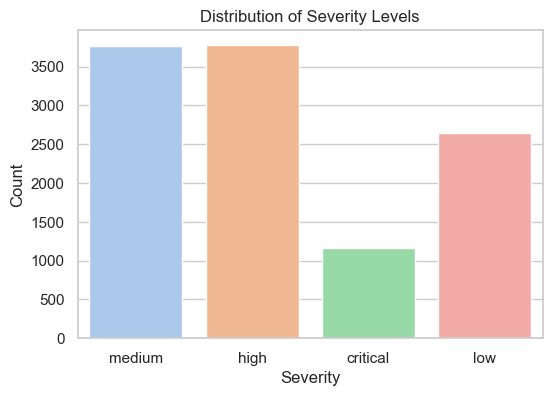

In [9]:
# %% [markdown]
# ## 3. Exploratory Data Analysis (EDA)
#
# We explore the data to understand its structure and balance.
#
# ### 3.1. Distribution of Severity Levels
#
# We plot a countplot to see how many records we have per severity level.

plt.figure(figsize=(6,4))
sns.countplot(x='parsed_data.severity', data=df, palette='pastel')
plt.title("Distribution of Severity Levels")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()


ValueError: cannot reindex on an axis with duplicate labels

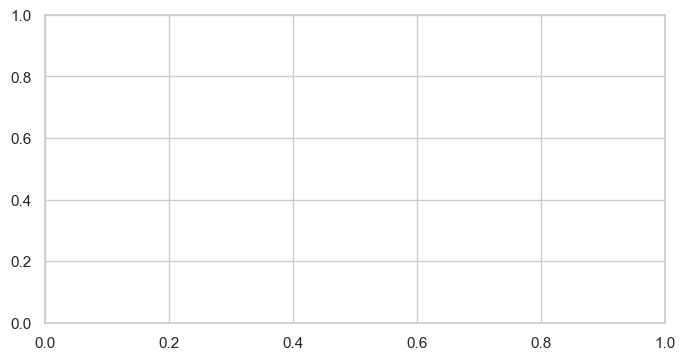

In [10]:
# %% [markdown]
# ### 3.2. Distribution of Categories in 'cats'
#
# The "parsed_data.cats" field is a list. We explode it so that we can see the frequency of each category.

# Explode the 'parsed_data.cats' list into separate rows
df_exploded = df.explode('parsed_data.cats')

plt.figure(figsize=(8,4))
sns.countplot(x='parsed_data.cats', data=df_exploded, palette='muted')
plt.title("Distribution of Categories (cats)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [11]:
# %% [markdown]
# ## 4. Preparing Data for the Classification Model
#
# In this example, we will predict the severity level based on the text.
#
# - **Feature:** `raw_data.text`
# - **Target:** `parsed_data.severity`

# Check for missing values in the text and severity fields
print("Missing text values:", df['raw_data.text'].isnull().sum())
print("Missing severity values:", df['parsed_data.severity'].isnull().sum())

# Select features and target
X = df['raw_data.text']
y = df['parsed_data.severity']

# Show the distribution of the target variable
print("\nSeverity value counts:")
print(y.value_counts())


Missing text values: 0
Missing severity values: 0

Severity value counts:
parsed_data.severity
high        3782
medium      3765
low         2644
critical    1165
Name: count, dtype: int64


In [12]:
# %% [markdown]
# ## 5. Text Preprocessing and Feature Extraction
#
# We convert the text data into numerical features using TF-IDF vectorization.

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer with English stop words
tfidf = TfidfVectorizer(stop_words='english')

# Fit the vectorizer on the training text and transform both training and testing data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [13]:
# %% [markdown]
# ## 6. Train the Classification Model
#
# We use Logistic Regression for this example. You can try other classifiers if needed.

# Initialize and train the Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, random_state=42)

Classification Report:
              precision    recall  f1-score   support

    critical       0.76      0.27      0.40       238
        high       0.62      0.71      0.66       801
         low       0.63      0.57      0.60       480
      medium       0.56      0.62      0.59       753

    accuracy                           0.60      2272
   macro avg       0.64      0.54      0.56      2272
weighted avg       0.62      0.60      0.60      2272



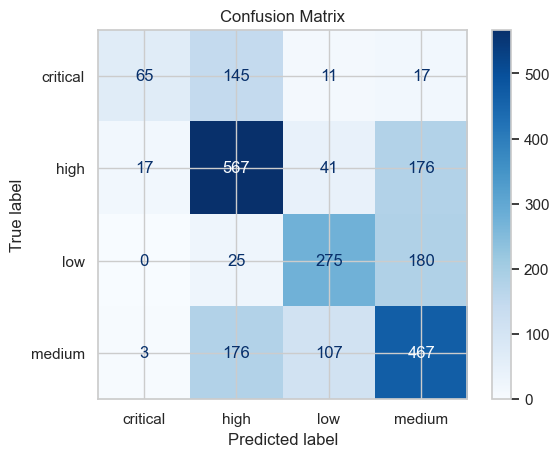

In [14]:
# %% [markdown]
# ## 7. Evaluate the Model
#
# We generate predictions on the test set, print a detailed classification report,
# and display a confusion matrix to visualize model performance.

# Predict the test set results
y_pred = clf.predict(X_test_tfidf)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


First few rows of the DataFrame:
  nlp_tasks                                      raw_data.text  \
0      None  Or some variation. I really am not suicidal, b...   
1      None  Trigger Warning: Mentions of different types S...   
2      None  To anyone feeling like they don't want to be h...   
3      None  I've been so stressed lately, but so far I've ...   
4      None  Here’s something I made after watching the fir...   

  raw_data.subreddit raw_data.category raw_data.id  \
0            r/CPTSD           r/CPTSD     1c2v3y0   
1         r/selfharm        r/selfharm     1g9whaj   
2     r/SuicideWatch    r/SuicideWatch     1ec794w   
3    r/AdultSelfHarm   r/AdultSelfHarm     1eir6ij   
4    r/troubledteens   r/troubledteens     1bvctis   

                                   parsed_data.query  \
0  Experiencing intrusive thoughts about self-har...   
1  Post listing various self-harm methods while s...   
2  Individual expressing chronic suicidal thought...   
3  Individual express

/var/folders/h4/8l1qm8k97mn4whg778yd7ckw0000gn/T/ipykernel_5323/933121281.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


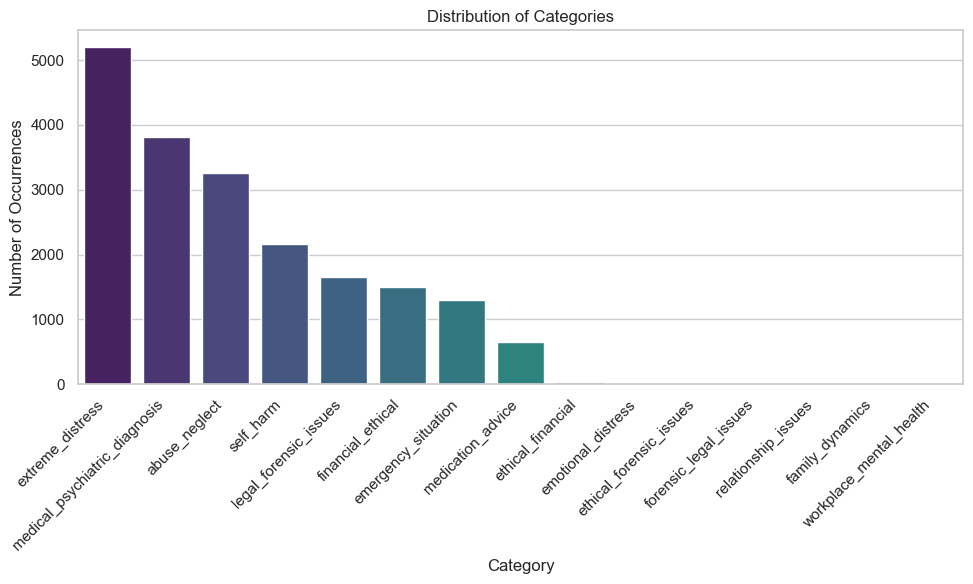


Category Counts:
categories
extreme_distress                 5197
medical_psychiatric_diagnosis    3814
abuse_neglect                    3258
self_harm                        2163
legal_forensic_issues            1648
financial_ethical                1501
emergency_situation              1301
medication_advice                 654
ethical_financial                  28
emotional_distress                  7
ethical_forensic_issues             3
forensic_legal_issues               1
relationship_issues                 1
family_dynamics                     1
workplace_mental_health             1
Name: count, dtype: int64


/var/folders/h4/8l1qm8k97mn4whg778yd7ckw0000gn/T/ipykernel_5323/933121281.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='severity', data=df, order=['low', 'medium', 'high', 'critical'], palette="plasma") # Specify order if levels are ordinal


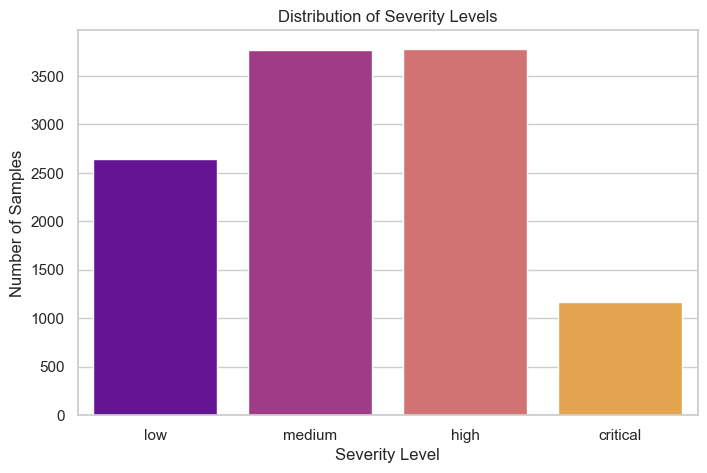


Severity Level Counts:
severity
high        3782
medium      3765
low         2644
critical    1165
Name: count, dtype: int64


/var/folders/h4/8l1qm8k97mn4whg778yd7ckw0000gn/T/ipykernel_5323/933121281.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='immediate_action_required', data=df, palette="coolwarm")


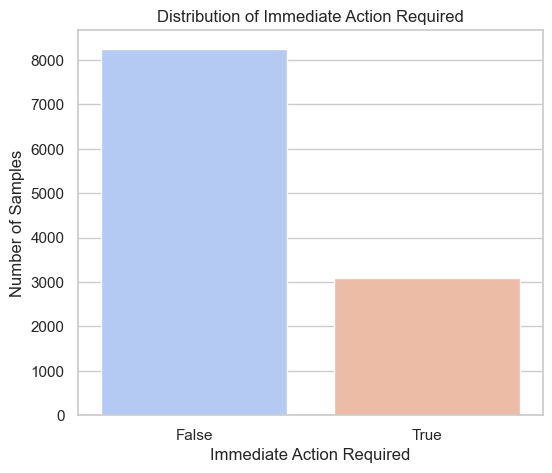


Immediate Action Required Counts:
immediate_action_required
False    8259
True     3097
Name: count, dtype: int64


/var/folders/h4/8l1qm8k97mn4whg778yd7ckw0000gn/T/ipykernel_5323/933121281.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subreddit_counts.index, y=subreddit_counts.values, palette="mako")


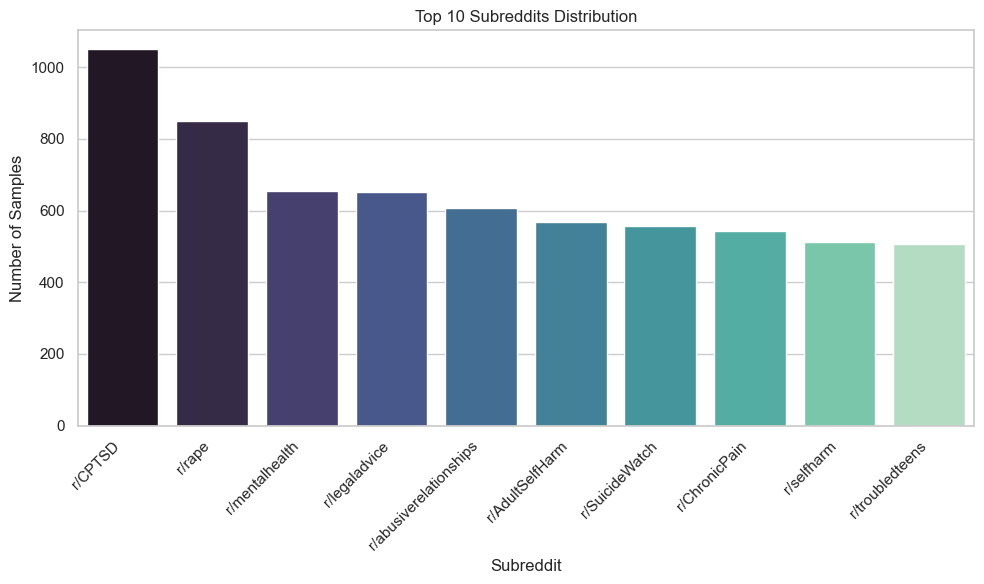


Top 10 Subreddit Counts:
subreddit
r/CPTSD                   1050
r/rape                     851
r/mentalhealth             654
r/legaladvice              653
r/abusiverelationships     607
r/AdultSelfHarm            568
r/SuicideWatch             558
r/ChronicPain              544
r/selfharm                 513
r/troubledteens            506
Name: count, dtype: int64
--- Data Report for Classification Model ---

1. Category Balance:
Category Counts:
 categories
extreme_distress                 5197
medical_psychiatric_diagnosis    3814
abuse_neglect                    3258
self_harm                        2163
legal_forensic_issues            1648
financial_ethical                1501
emergency_situation              1301
medication_advice                 654
ethical_financial                  28
emotional_distress                  7
ethical_forensic_issues             3
forensic_legal_issues               1
relationship_issues                 1
family_dynamics                     1


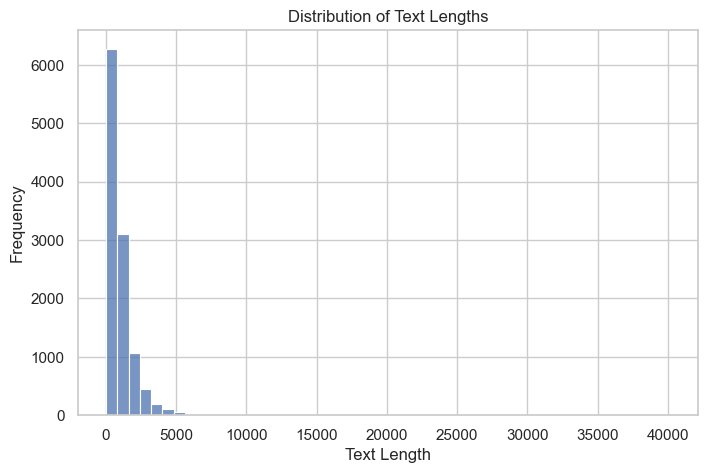


--- End of Data Report ---


In [18]:
# %%
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# %% [markdown]
# ## 2. Load and Prepare the Data
#
# Here, we load the JSON file and normalize it into a flat DataFrame.
# In this example, we assume the JSON file contains a list of records.

# Replace 'data.json' with the path to your JSON file.
with open('/Users/shrijayan.rajendran/projects/personal/monk/monk_modernbert/dataset/medical_mimic_new_(1) copy.json', 'r') as f:
    data = json.load(f)

# Normalize the nested JSON structure
df = pd.json_normalize(data)

# Display the first few rows to understand the data structure
df.head()


print("First few rows of the DataFrame:")
print(df.head())

print("\nDataFrame Information:")
df.info()

# %% [markdown]
# ## 3. Data Preparation and Feature Extraction
#
# Based on the normalized DataFrame structure from `pd.json_normalize`, we will extract the relevant columns for analysis.
# Let's examine `df.columns` to identify the correct column names after normalization.

# Print column names to identify the flattened structure
print("\nColumns after normalization:")
print(df.columns)

# Now, based on the column names (from df.columns output - you might need to run the previous cell to see it),
# we will extract the features. Adjust these column names if they are different in your DataFrame.

df['text'] = df['raw_data.text']
df['subreddit'] = df['raw_data.subreddit']
df['categories'] = df['parsed_data.cats']
df['severity'] = df['parsed_data.severity']
df['immediate_action_required'] = df['parsed_data.immediate_action_required']

# Display the first few rows with extracted columns
print("\nFirst few rows with extracted columns:")
print(df[['text', 'subreddit', 'categories', 'severity', 'immediate_action_required']].head())

# %% [markdown]
# ## 4. Data Visualization
#
# We will now create visualizations to understand the distribution of key features in the dataset.

# %% [markdown]
# ### 4.1. Category Distribution

# Explode categories to count individual categories
category_series = df['categories'].explode()
category_counts = category_series.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

print("\nCategory Counts:")
print(category_counts)

# %% [markdown]
# ### 4.2. Severity Distribution

severity_counts = df['severity'].value_counts(dropna=False) # Include NaN values if any

plt.figure(figsize=(8, 5))
sns.countplot(x='severity', data=df, order=['low', 'medium', 'high', 'critical'], palette="plasma") # Specify order if levels are ordinal
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Number of Samples')
plt.show()

print("\nSeverity Level Counts:")
print(severity_counts)

# %% [markdown]
# ### 4.3. Immediate Action Required Distribution

immediate_action_counts = df['immediate_action_required'].value_counts(dropna=False)

plt.figure(figsize=(6, 5))
sns.countplot(x='immediate_action_required', data=df, palette="coolwarm")
plt.title('Distribution of Immediate Action Required')
plt.xlabel('Immediate Action Required')
plt.ylabel('Number of Samples')
plt.show()

print("\nImmediate Action Required Counts:")
print(immediate_action_counts)

# %% [markdown]
# ### 4.4. Subreddit Distribution

subreddit_counts = df['subreddit'].value_counts().nlargest(10) # Top 10 subreddits

plt.figure(figsize=(10, 6))
sns.barplot(x=subreddit_counts.index, y=subreddit_counts.values, palette="mako")
plt.title('Top 10 Subreddits Distribution')
plt.xlabel('Subreddit')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nTop 10 Subreddit Counts:")
print(subreddit_counts)

# %% [markdown]
# ## 5. Detailed Report for Classification Model

print("--- Data Report for Classification Model ---")

# %% [markdown]
# ### 5.1. Data Balance for Categories

print("\n1. Category Balance:")
print("Category Counts:\n", category_counts)
total_samples = len(df)
print("\nCategory Proportions:")
for category, count in category_counts.items():
    proportion = (count / total_samples) * 100
    print(f"- {category}: {proportion:.2f}%")

# Assess balance - a very basic check, you might need more sophisticated metrics
print("\nBalance Assessment:")
if category_counts.max() / category_counts.min() > 10: # Example threshold, adjust as needed
    print("  - Categories are likely imbalanced based on simple max/min ratio.")
    print("  - Consider techniques like oversampling, undersampling, or class weights during model training.")
else:
    print("  - Categories appear to be relatively balanced (based on simple max/min ratio).")

# %% [markdown]
# ### 5.2. Missing Data Check

print("\n2. Missing Data Check:")
missing_data = df.isnull().sum()
print(missing_data)
print("\nPercentage of Missing Data:")
print((missing_data / len(df)) * 100)

# %% [markdown]
# ### 5.3. Data Types

print("\n3. Data Types:")
print(df.dtypes)

# %% [markdown]
# ### 5.4. Text Data Sample and Length Analysis (Optional but Recommended for Text Classification)

print("\n4. Text Data Sample and Length Analysis (Optional):")
print("Sample Text (first example):\n", df['text'].iloc[0] if not df['text'].empty else "No text available")
df['text_length'] = df['text'].str.len()
print("\nText Length Statistics:")
print(df['text_length'].describe())
plt.figure(figsize=(8, 5))
sns.histplot(df['text_length'].dropna(), bins=50) # Histogram of text lengths
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

print("\n--- End of Data Report ---")